# Deep Learning (RNN model)

## Imports

In [128]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf

2023-03-18 21:55:47.213144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 21:55:47.506834: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 21:55:47.583287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-18 21:55:47.583302: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [80]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/home/galinasamotorova/code/GalinaSa/Final-Project'

## Import the data

In [81]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = 'data'
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [82]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


In [83]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

## Data cleaning

### Drop features with all NaN and >30% NaN values

In [84]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)
df.shape

(5813, 65)

### Drop features with std = 0

In [85]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

df.shape

(5813, 41)

### Drop corrected, 'choke' and correlated features, and from 'remove' dict

In [86]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

In [87]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

In [88]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

In [89]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P", "Service Line P", "Manifold T", "Jumper T"}
df.drop(columns=remove, inplace=True)

In [90]:
df.shape

(5813, 14)

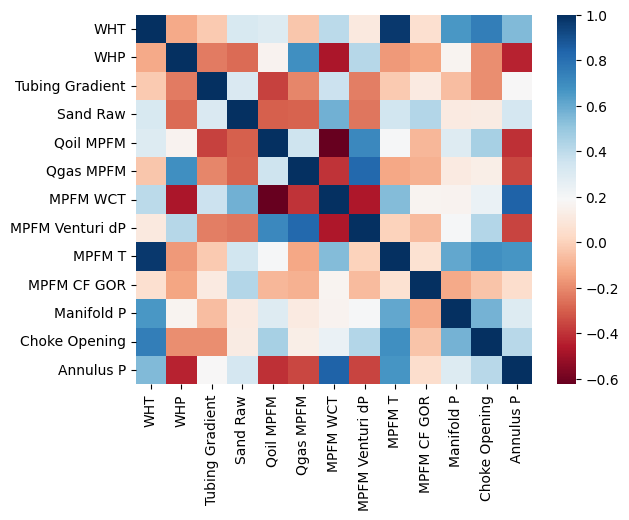

In [91]:
# Pairwise correlation
sns.heatmap(df.corr(), cmap='RdBu')
plt.show()

## Impute features

In [92]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [93]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold P         0
Choke Opening      0
Annulus P          0
dtype: int64

In [94]:
df.head()

,Date,WHT,WHP,Tubing Gradient,Sand Raw,Qoil MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold P,Choke Opening,Annulus P
0,2007-02-01,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
1,2007-02-02,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
2,2007-02-03,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
3,2007-02-04,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
4,2007-02-05,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353


## Feature selection

In [99]:
# starting the first model with 4 features only + our Target 'Qoil MPFM':

df_f = df[["Date","Qoil MPFM","MPFM WCT","Annulus P", "Tubing Gradient", "MPFM Venturi dP"]].copy()

In [100]:
df_f.shape

(5813, 6)

## Visualizing Time Series

In [106]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df_f.shape[1] - 1

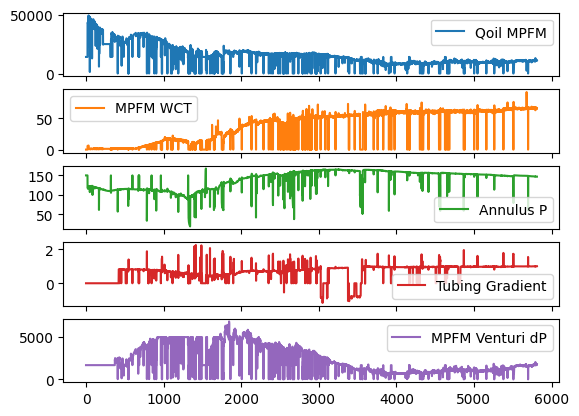

In [109]:
plot_cols = [TARGET, 'MPFM WCT','Annulus P', 'Tubing Gradient', 'MPFM Venturi dP']
plot_features = df_f[plot_cols]
plot_features.index = df_f.index
plot_features.plot(subplots = True);

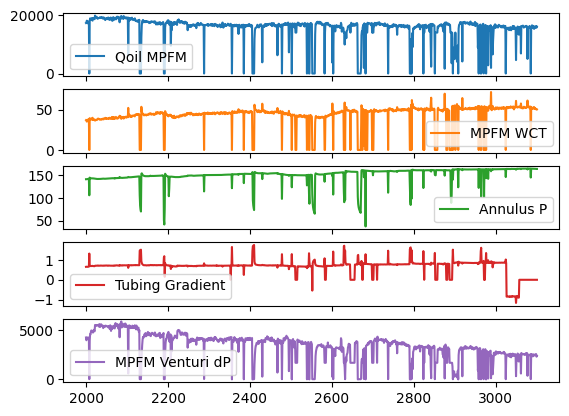

In [110]:
zoomed_slice = slice(2000,3100)

plot_features = df_f.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Preparing the dataset

In [111]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 3 # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [112]:
def get_folds(
    df_f: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df_f), fold_stride):
        if i + fold_length >= len(df_f):
            break
        fold_list.append(df_f[i:fold_length])
    
    return fold_list

In [113]:
folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 52 folds.
Each fold has a shape equal to (1095, 6).


### Temporal Train/Test split

Let's focus on one fold

In [114]:
fold = folds[0]
fold

,Date,Qoil MPFM,MPFM WCT,Annulus P,Tubing Gradient,MPFM Venturi dP
0,2007-02-01,14065.431937,0.000000,150.246353,0.000000,1672.997986
1,2007-02-02,14065.431937,0.000000,150.246353,0.000000,1672.997986
2,2007-02-03,14065.431937,0.000000,150.246353,0.000000,1672.997986
3,2007-02-04,14065.431937,0.000000,150.246353,0.000000,1672.997986
4,2007-02-05,14065.431937,0.000000,150.246353,0.000000,1672.997986
...,...,...,...,...,...,...
1090,2010-01-26,23788.793743,16.810093,106.314453,0.692401,5000.000000
1091,2010-01-27,23831.706038,16.221851,106.136719,0.691799,5000.000000
1092,2010-01-28,22478.727202,17.043915,106.222321,0.673693,4833.718262
1093,2010-01-29,22362.401021,15.439603,106.204193,0.665585,4847.751953


☝️ We want to split this fold chronologically into:

- train dataframe
- test dataframe

that will contain all the data we need to be able to sample many (X_i, y_i) pairs in each dataframe in a next step!

The INPUT_LENGTH of each X_i is going to be equal to 2 weeks (*but we can change it*)

In [115]:
INPUT_LENGTH = 14 # two weeks

In [116]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [117]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [118]:
print(f'Each fold has a shape equal to {fold.shape}.')
print(f'Each fold_train has a shape equal to {fold_train.shape}.')
print(f'Each fold_test has a shape equal to {fold_test.shape}.')

Each fold has a shape equal to (1095, 6).
Each fold_train has a shape equal to (723, 6).
Each fold_test has a shape equal to (386, 6).


### Create (X, y) sequences

Now that we have splitted our fold into a train set and a test set, it is time to:

- sample lots of sequences (Xi,yi) on which the model will be trained
- sample lots of sequences (Xi,yi)on which the model will be evaluated

Our goal is to create 3D-arrays (X_train, y_train) and (X_test, y_test) containing all the SEQUENCES we need from this fold:

- X_train.shape = (n_samples_train, input_length, n_features)
- y_train.shape = (n_samples_train, output_length, n_targets)

In [119]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 5
INPUT_LENGTH = 14 days = 2 weeks


X is the input of our model.

- It contains 5 features: the past values of the target + 4 past-covariates
- Each sequence has a length equal to 2 weeks

In [120]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


y is the target that we want to predict

- It is the value at the single next timestep (= next day)
 - We could also predict OUTPUT_LENGTH > 1, i.e several values in the future (2, 3 days later,...) but let's keep it simple here and just try to predict the next point (next day)

### Creating the (X,y) sequences by random sampling in each fold

Generating one random sequence

In [121]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [122]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [124]:
X_train_i.shape

(14, 6)

In [125]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

Generating multiple random sequence

In [126]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [127]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

## Modeling

## Exporting model

In [157]:
import pickle

# Export Baseline Model as pickle file
with open("baseline_model.pkl", "wb") as file:
    pickle.dump(baseline_model, file)

# Load Baseline Model from pickle file
my_model = pickle.load(open("baseline_model.pkl","rb"))

my_model.score(X_test_drop, y_test)

0.17962516068093193